In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import img_to_array, array_to_img

import matplotlib.pyplot as plt

In [2]:
# set the seed for reproducibility of the results
tf.random.set_seed(1)

In [3]:
# load the data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
# convert images to rgb
train_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(train_images, -1))
test_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(test_images, -1))

num_classes = len(np.unique(train_labels))

# resize the images to a compatible with vgg16 size
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_rgb])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_rgb])

Metal device set to: Apple M2 Pro


In [5]:
# preprocess the images for vgg16
train_X = tf.keras.applications.vgg16.preprocess_input(train_X)
test_X = tf.keras.applications.vgg16.preprocess_input(test_X)

In [6]:
# define the base model
base_model = VGG16(include_top=False, weights="imagenet", input_shape=(48, 48, 3))

# freeze the weights of the base model
base_model.trainable = False

In [7]:
# stack a small model for classification on top of the base one
inputs = tf.keras.Input(shape=(48, 48, 3))
x = BatchNormalization()(inputs)
x = base_model(x, training=False)
x = GlobalMaxPooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

logits = Dense(num_classes, activation='linear')(x)

In [8]:
# compile the model
model = Model(inputs=inputs, outputs=logits)

model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [9]:
epochs = 20
batch_size = 256

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

checkpoint_filepath = 'best_weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-6)

# train the model
history = model.fit(train_X, train_labels, epochs=epochs, batch_size=batch_size, callbacks=[early_stop, 
                    checkpoint_callback, reduce_lr], validation_split=0.2)

Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.7607
Epoch 1: val_accuracy improved from -inf to 0.84400, saving model to best_weights.h5
188/188 [==============================] - 39s 204ms/step - loss: 0.6896 - accuracy: 0.7607 - val_loss: 0.4335 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8424
Epoch 2: val_accuracy improved from 0.84400 to 0.85867, saving model to best_weights.h5
188/188 [==============================] - 38s 202ms/step - loss: 0.4399 - accuracy: 0.8424 - val_loss: 0.3859 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8565
Epoch 3: val_accuracy improved from 0.85867 to 0.86700, saving model to best_weights.h5
188/188 [==============================] - 38s 203ms/step - loss: 0.3943 - accuracy: 0.8565 - val_loss: 0.3582 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 4/20

In [10]:
def plot_acc_curves(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
    
def plot_cost_curves(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Cost')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

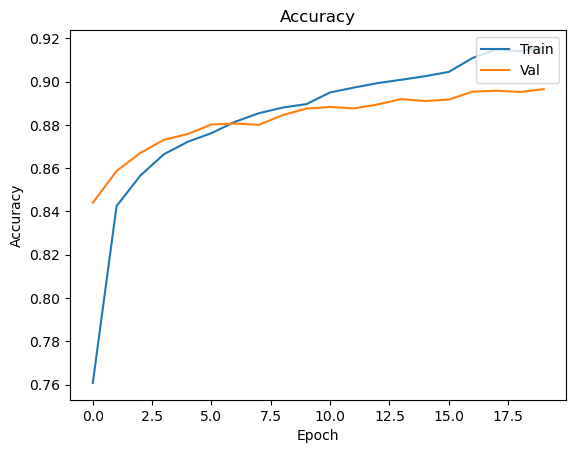

In [11]:
# plot accuracy curves
plot_acc_curves(history)

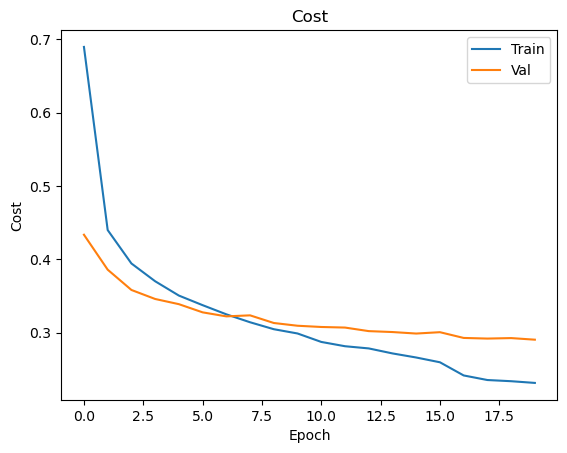

In [12]:
# plot loss curves
plot_cost_curves(history)

In [13]:
# test the model on the test set
model.load_weights(checkpoint_filepath)

test_logits = model.predict(test_X)
test_pred = tf.nn.softmax(test_logits)

loss, acc = model.evaluate(test_X, test_labels)

313/313 [==============================] - 5s 14ms/step - loss: 0.3178 - accuracy: 0.8901


In [14]:
acc

0.8901000022888184

The accuracy is not good enough, so we will try some fine-tuning.

In [15]:
def show_img(i, pred, label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
    
    pred_label = np.argmax(pred)
    
    plt.xlabel(f'Pred: {pred_label}, {round(100*np.max(pred), 1)}%, true: {label}. {pred_label == label}')
               
               
def show_preds_arr(i, pred, label):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), pred, color='#777777')
    
    plt.ylim([0, 1])
    pred_label = np.argmax(pred)
    
    thisplot[pred_label].set_color('red')
    thisplot[label].set_color('blue')

In [16]:
# unfreeze the base model
base_model.trainable = True

# recompile the mode
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=1e-8)

# fine-tune
history_fine_tuning = model.fit(train_X, train_labels, epochs=10, batch_size=32, callbacks=[checkpoint_callback,
                                reduce_lr], validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9045
Epoch 1: val_accuracy improved from 0.89650 to 0.91233, saving model to best_weights.h5
1500/1500 [==============================] - 72s 48ms/step - loss: 0.2620 - accuracy: 0.9045 - val_loss: 0.2388 - val_accuracy: 0.9123 - lr: 1.0000e-05
Epoch 2/10
1499/1500 [============================>.] - ETA: 0s - loss: 0.1953 - accuracy: 0.9286
Epoch 2: val_accuracy improved from 0.91233 to 0.92075, saving model to best_weights.h5
1500/1500 [==============================] - 71s 47ms/step - loss: 0.1953 - accuracy: 0.9287 - val_loss: 0.2183 - val_accuracy: 0.9208 - lr: 1.0000e-05
Epoch 3/10
1500/1500 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9400
Epoch 3: val_accuracy improved from 0.92075 to 0.92300, saving model to best_weights.h5
1500/1500 [==============================] - 71s 47ms/step - loss: 0.1604 - accuracy: 0.9400 - val_loss: 0.2168 - val_accuracy: 0.9230 - l

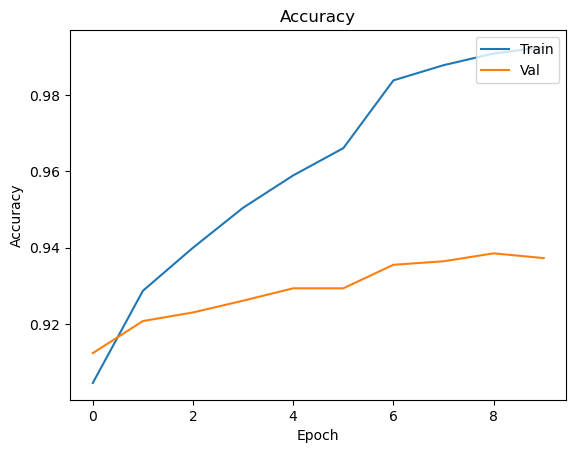

In [17]:
plot_acc_curves(history_fine_tuning)

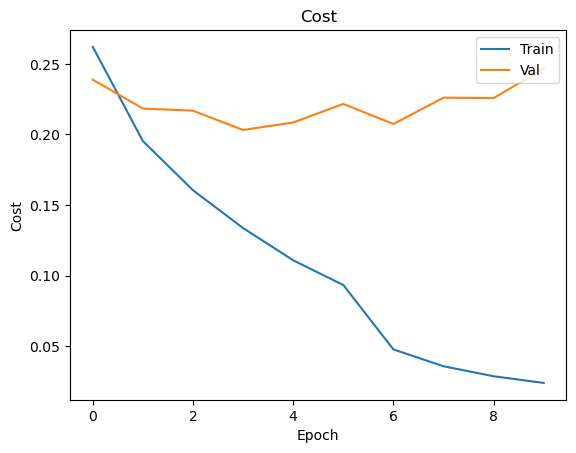

In [18]:
plot_cost_curves(history_fine_tuning)

In [19]:
model.load_weights(checkpoint_filepath)

test_logits = model.predict(test_X)
test_pred = tf.nn.softmax(test_logits)

loss, acc = model.evaluate(test_X, test_labels)

313/313 [==============================] - 5s 14ms/step - loss: 0.2558 - accuracy: 0.9356


In [20]:
acc

0.9355999827384949

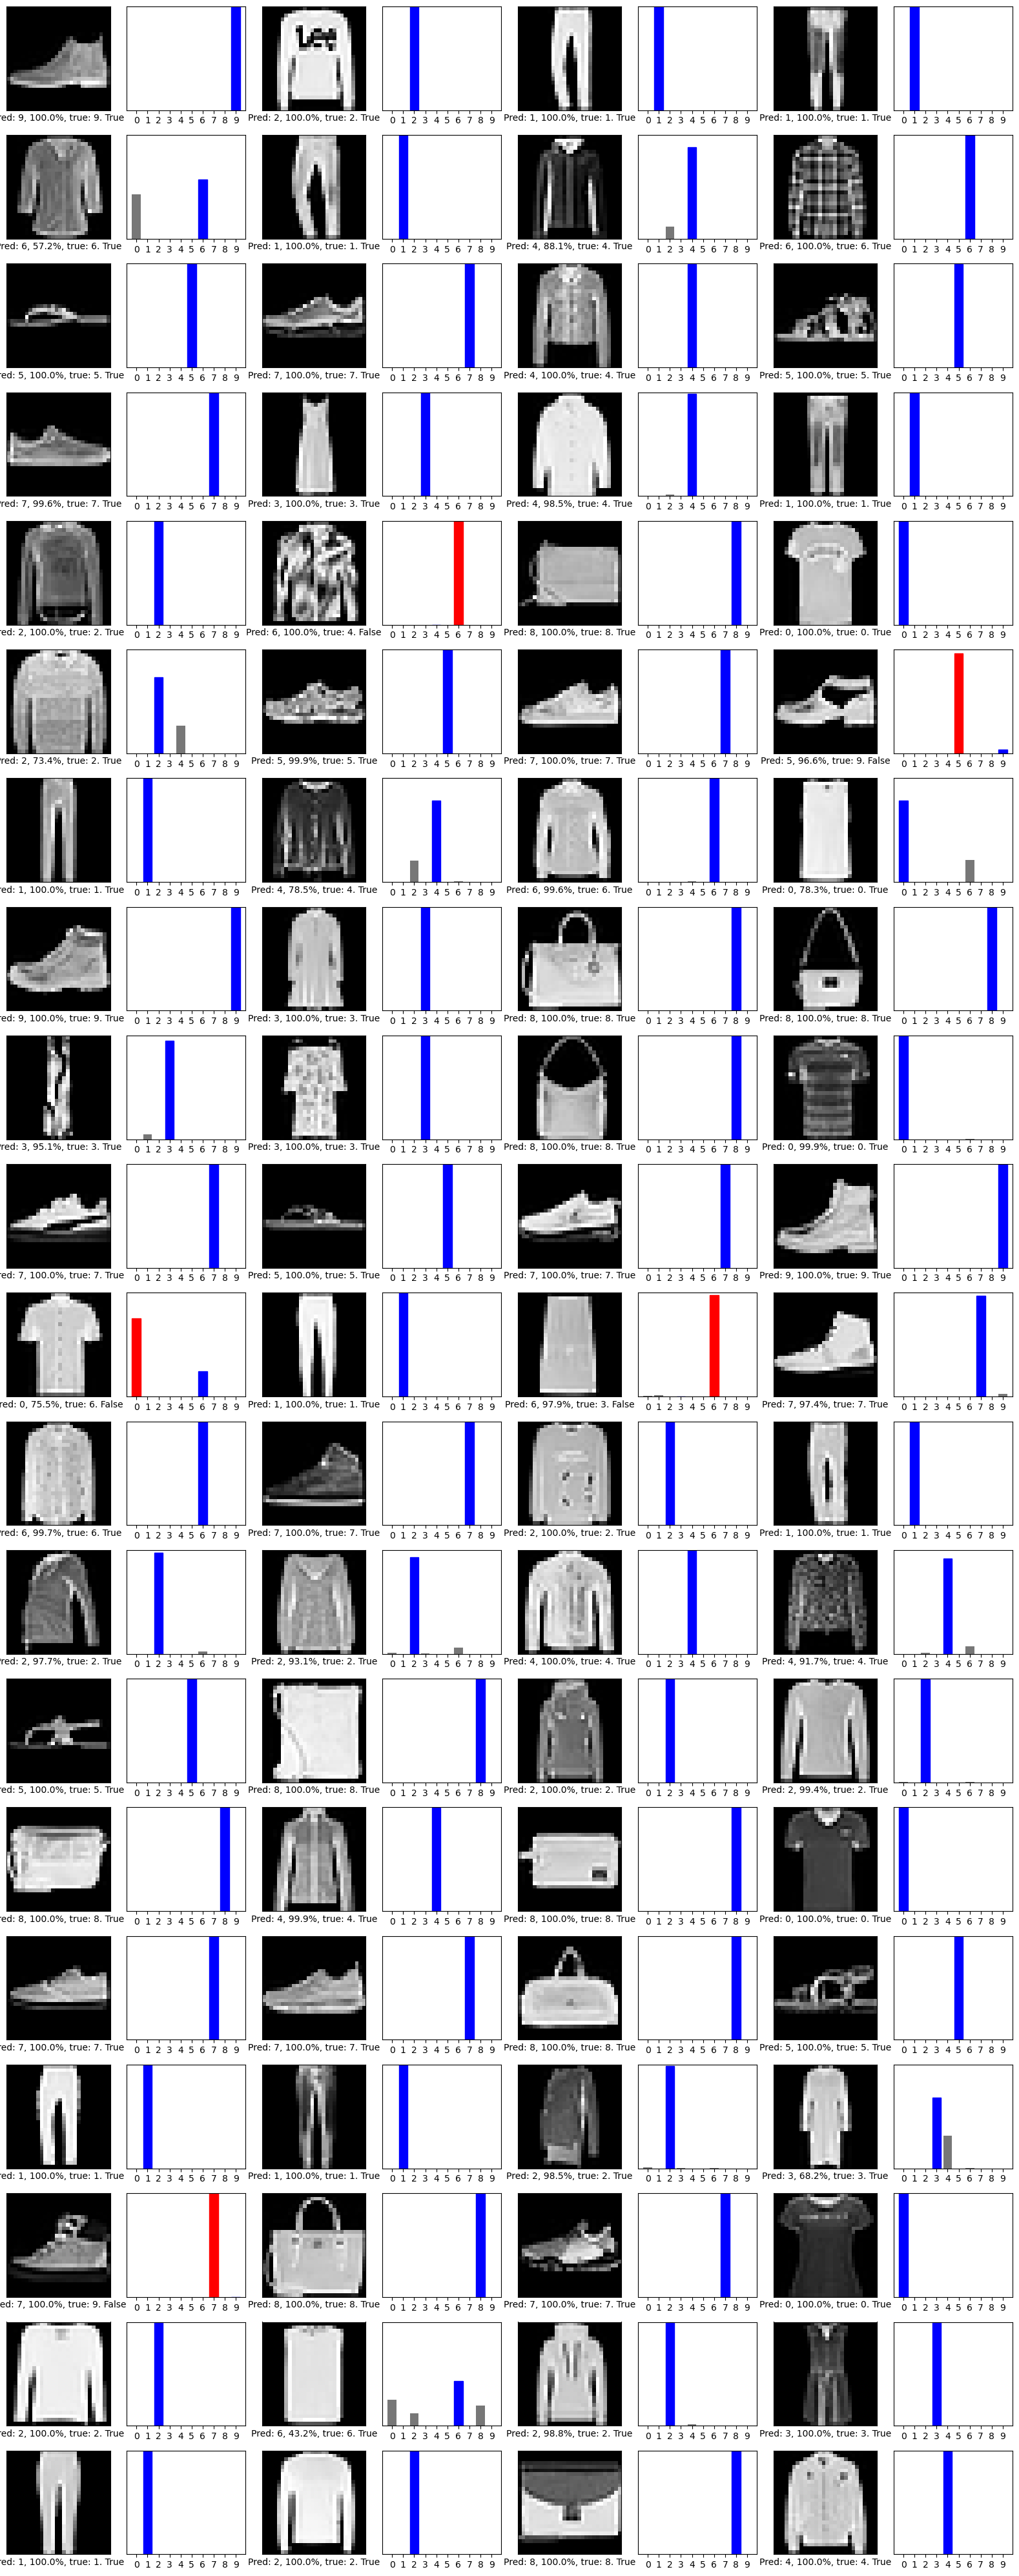

In [23]:
num_rows = 20
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    show_img(i, test_pred[i], test_labels[i], test_images[i])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    show_preds_arr(i, test_pred[i], test_labels[i])
plt.tight_layout()
plt.show()

VGG16 is a bit more accurate in its predictions, but in general it was trained on a training set which is a lot different from fashion-mnist, so additional resizing and adding 3 color channels had to be performed. Eventually, the VGG16 model shows almost ideal performance on the training set and an increased performance compared to the smaller convolutional network.